# Download Images

In [1]:
import os
img_dir = '/tmp/deep_transfer'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget https://storage.googleapis.com/style_transfer_git/Images.zip\
    -O /tmp/Images.zip

--2019-07-24 17:33:46--  https://storage.googleapis.com/style_transfer_git/Images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.10.112
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.10.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2851400 (2.7M) [application/zip]
Saving to: ‘/tmp/Images.zip’

/tmp/Images.zip     100%[===================>]   2.72M  2.24MB/s    in 1.2s    

2019-07-24 17:33:48 (2.24 MB/s) - ‘/tmp/Images.zip’ saved [2851400/2851400]



In [2]:
import zipfile
local_zip = '/tmp/Images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/style_transfer')
zip_ref.close()

In [3]:
print('Style')
!ls '/tmp/style_transfer/Images/Content/'
print('\n')
print('Content')
!ls '/tmp/style_transfer/Images/Style/'

Style
IMG_0153.jpg    cuba_phoebe.jpg love.jpg        princesse.jpg


Content
blue_art.jpg      ciel_art.jpeg     flamme_flower.jpg


# Import Librairies and configuration

In [4]:
import numpy as np
import time
import functools

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.applications import vgg19
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [6]:
# Set up some global values here
content_path = '/tmp/style_transfer/Images/Content/princesse.jpg'
style_path = '/tmp/style_transfer/Images/Style/flamme_flower.jpg'

# Visualize the images

In [7]:
from PIL import Image

def load_img(path_to_img, max_dim = 512):
    
    # load image
    img = Image.open(path_to_img)
    
    # resize image
    scale = max_dim/max(img.size)
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS) #The last parameter is optional, it is a high-quality downsampling filter
    
    # keras preprocessing to transform the resized image into an array
    img = image.img_to_array(img)
  
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    
    return img

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.grid'] = False

def imshow(img, title):
    
    img = img.astype('uint8')
    
    # Remove the batch dimension
    out = np.squeeze(img, axis=0).astype('uint8')
    
    plt.imshow(out)
    plt.title(title)
    plt.imshow(out)

These are input content and style images. We hope to "create" an image with the content of our content image, but with the style of the style image.

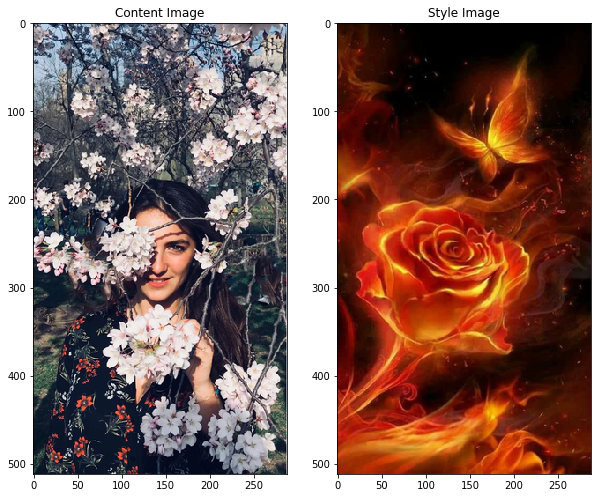

In [9]:
plt.figure(figsize=(10,10))

content = load_img(content_path)
style = load_img(style_path)
plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

# Data Preprocessing
In order to create a batch of images, you need an additional dimension: (samples, size1,size2,channels). The preprocess_input function is meant to adequate your image to the format the model requires. VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels BGR so we add this step in the preprocessing.

In [10]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img, max_dim = 512)
    img = vgg19.preprocess_input(img)
    return img

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore, since our optimized image may take its values anywhere between  −∞  and  ∞ , we must clip to maintain our values from within the 0-255 range.

In [11]:
def inverse_preprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Build Model

We select intermediate layers of the pretrained model to capture the representation of the style and context. The deeper the layers, the higher the features are

In [12]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

We build a slightly different version of the vgg19 by accessing the previously determine intermediate layers

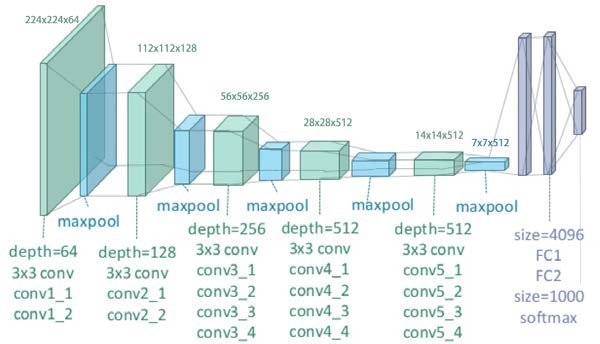[credit : https://www.researchgate.net/figure/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356]

In [13]:
def get_model():

    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(layer).output for layer in style_layers]
    content_outputs = [vgg.get_layer(layer).output for layer in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # Build model : With the Functional API defining a model simply involves defining the input and output
    return Model(vgg.input, model_outputs)

## Loss functions

A very interesting article to understand loss function for style transfer : https://towardsdatascience.com/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916

The content_loss function correspond to the distance between the original content and its feature representation in the intermediate layer. We use least square error to minimize the distance. We use the feature representation because it contain mainly a sketch of the content without the 'style' of the original content.

In [14]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

For the style_loss, it is a bit different. We can't just compare the input and intermediate output. We will compare the distance between their gram matrix which represent their 'style'.

The gram matrix is the matrix representation of the dot product between every flattened vector from a convolutional features map.

In [15]:
def gram_matrix(input_tensor):
    # We make the image channels first. Originally, the input tensor dimension are : batch size, height, width, channel
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
  
    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

An amazing ressource to understand gradient descent is this article : http://ruder.io/optimizing-gradient-descent/

In [16]:
def get_feature_representations(model, content_path, style_path):
    # Load and preprocess images
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
  
    # compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
  
  
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [17]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

    style_weight, content_weight = loss_weights
  
    # Using eager execution allow us to call the model function as any function using init_image as input
    model_outputs = model(init_image)
  
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
  
    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [18]:
def compute_grads(cfg): #cfg is the configuration we define later
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [19]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    # We don't need to (or want to) train any layers of our model, so we set their trainable to false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    iter_count = 1
  
    # Store our best result
    best_loss, best_img = float('inf'), None
  
    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = inverse_preprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()
      
            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = inverse_preprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss 

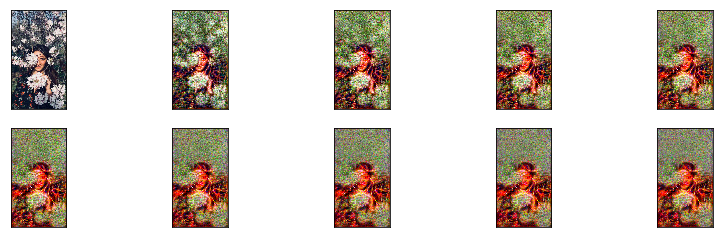

In [20]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=500)

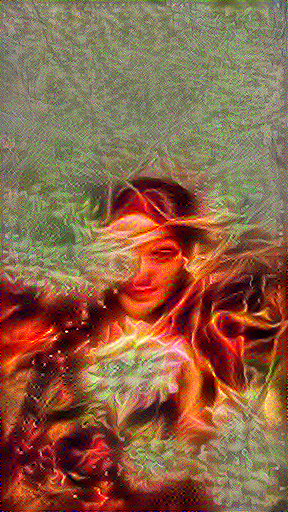

In [21]:
Image.fromarray(best)

# Visualize outputs
We apply inverse transformation to the output image in order to remove the processing that was applied to it.

In [22]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

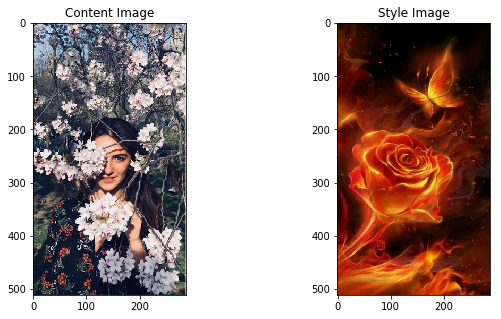

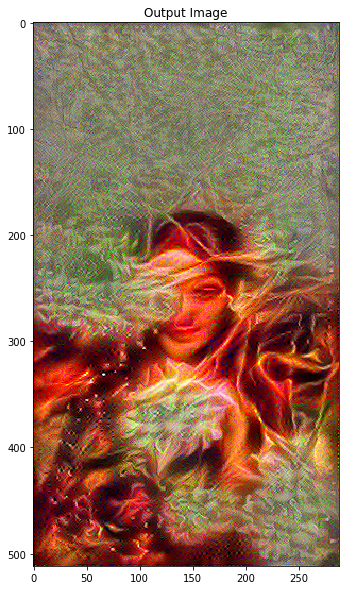

In [23]:
show_results(best, content_path, style_path)